## Load Data

In [15]:
!nvidia-smi #py 3.10.11

ERROR: Option #py is not recognized. Please run 'nvidia-smi -h'.



In [18]:
#Count data
import os

# Define the paths to the directories
train_dir = "./../../data/train/"
test_dir = "./../../data/test/"

categories = [
    "ALGAL_LEAF_SPOT",
    "ALLOCARIDARA_ATTACK",
    "HEALTHY_LEAF",
    "LEAF_BLIGHT",
    "PHOMOPSIS_LEAF_SPOT"
]

print("--- Training Set File Counts ---")
for category in categories:
    dir_path = os.path.join(train_dir, category)
    try:
        count = len(os.listdir(dir_path))
        print(f"Number of files in {dir_path}: {count}")
    except FileNotFoundError:
        print(f"Directory not found: {dir_path}")
    except Exception as e:
        print(f"An error occurred for {dir_path}: {e}")

print("\n--- Test Set File Counts ---")
for category in categories:
    dir_path = os.path.join(test_dir, category)
    try:
        count = len(os.listdir(dir_path))
        print(f"Number of files in {dir_path}: {count}")
    except FileNotFoundError:
        print(f"Directory not found: {dir_path}")
    except Exception as e:
        print(f"An error occurred for {dir_path}: {e}")

--- Training Set File Counts ---
Number of files in ./../../data/train/ALGAL_LEAF_SPOT: 632
Number of files in ./../../data/train/ALLOCARIDARA_ATTACK: 787
Number of files in ./../../data/train/HEALTHY_LEAF: 841
Number of files in ./../../data/train/LEAF_BLIGHT: 808
Number of files in ./../../data/train/PHOMOPSIS_LEAF_SPOT: 757

--- Test Set File Counts ---
Number of files in ./../../data/test/ALGAL_LEAF_SPOT: 101
Number of files in ./../../data/test/ALLOCARIDARA_ATTACK: 126
Number of files in ./../../data/test/HEALTHY_LEAF: 135
Number of files in ./../../data/test/LEAF_BLIGHT: 129
Number of files in ./../../data/test/PHOMOPSIS_LEAF_SPOT: 121


# Install Timm

In [24]:
# Install Timm (Need to restart the runtime after finish install )
#pip install git+https://github.com/rwightman/pytorch-image-models.git
#%pip install lightning transformers datasets evaluate pillow 

In [19]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split, Dataset

# Pytorch Image model (TIMM) library: a library for state-of-the-art image classification
import timm
import timm.optim
import timm.scheduler
from timm.data import ImageDataset, create_dataset, create_loader
from timm.data.transforms_factory import create_transform
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from PIL import Image

import evaluate

import numpy as np
import pandas as pd
from scipy import stats

from tqdm.notebook import tqdm

import glob

from sklearn.model_selection import StratifiedKFold,KFold

from lightning.fabric import Fabric

from copy import copy

import shutil
import torchvision.transforms as transforms

from sklearn.utils.class_weight import compute_class_weight
from torchvision import datasets

## visualization Model

In [20]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    %pip install -q torchinfo
    from torchinfo import summary

In [21]:
# Select model (List of available is shown above)
efficientnetv2 = "efficientnetv2_rw_s"
efficientnetv2_model= timm.create_model(efficientnetv2, pretrained=True, num_classes=5)
# Print a summary using torchinfo (uncomment for actual output)
summary(model=efficientnetv2_model,
        input_size=(16, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                        [16, 3, 224, 224]    [16, 5]              --                   True
├─Conv2d (conv_stem)                               [16, 3, 224, 224]    [16, 24, 112, 112]   648                  True
├─BatchNormAct2d (bn1)                             [16, 24, 112, 112]   [16, 24, 112, 112]   48                   True
│    └─Identity (drop)                             [16, 24, 112, 112]   [16, 24, 112, 112]   --                   --
│    └─SiLU (act)                                  [16, 24, 112, 112]   [16, 24, 112, 112]   --                   --
├─Sequential (blocks)                              [16, 24, 112, 112]   [16, 272, 7, 7]      --                   True
│    └─Sequential (0)                              [16, 24, 112, 112]   [16, 24, 112, 112]   --                   True
│    │    └─EdgeResidual (0)                   

In [22]:
# Transform image data based on ImageNet's mean and std
data_transforms = { # เปลี่ยนชื่อตัวแปรเป็น data_transforms
    "train": T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=torch.tensor([0.4850, 0.4560, 0.4060]), std=torch.tensor([0.2290, 0.2240, 0.2250]))
    ]),
    "test": T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=torch.tensor([0.4850, 0.4560, 0.4060]), std=torch.tensor([0.2290, 0.2240, 0.2250]))
    ]),
}

In [23]:
dataset = datasets.ImageFolder(root=train_dir,
                               transform=data_transforms["train"], 
                               target_transform=None)

In [24]:
dataset.class_to_idx

{'ALGAL_LEAF_SPOT': 0,
 'ALLOCARIDARA_ATTACK': 1,
 'HEALTHY_LEAF': 2,
 'LEAF_BLIGHT': 3,
 'PHOMOPSIS_LEAF_SPOT': 4}

In [25]:
len(dataset)

3825

In [26]:
# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [27]:
#Select Model
model_name = "efficientnetv2_rw_s"

In [28]:
num_epochs = 5
criterion = nn.CrossEntropyLoss()

# Cross Validation Configuration
k_splits = 5
metric = evaluate.load("accuracy")

In [29]:
# Cross validation
kf = KFold(n_splits=k_splits, shuffle=True, random_state=42)

In [30]:
# Gradient Accumulation Settings
# Set to 1 for no accumulation
train_batch_size = 16
eval_batch_size = 8
num_accumulate = 1

In [31]:
torch.set_float32_matmul_precision('high')
#fabric = Fabric(accelerator="cuda", precision="16-mixed")
fabric = Fabric(accelerator="gpu", devices=1, precision="16-mixed")
fabric.launch()

Using 16-bit Automatic Mixed Precision (AMP)


In [32]:
import time

In [52]:
%%time
all_eval_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"Fold {fold+1} of {k_splits}")

    # Load Model
    model = timm.create_model(model_name, pretrained=True, num_classes=5)


    # Load Optimizer and Scheduler
    optimizer = timm.optim.create_optimizer_v2(model, opt="AdamW", lr=5e-4)
    # optimizer = timm.optim.Lookahead(optimizer, alpha=0.5, k=6)    # update the slow weight every k steps
                                                                   # update the optimizer by combine slow weight and fast weight * alpha

    model, optimizer = fabric.setup(model, optimizer)

    scheduler = timm.scheduler.create_scheduler_v2(optimizer, num_epochs=num_epochs)[0]

    # Load Data: split train and valition set based on kfold
    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)

    train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_dataloader = DataLoader(val_dataset, batch_size=eval_batch_size, shuffle=False, num_workers=4, pin_memory=True)

    train_dataloader, val_dataloader = fabric.setup_dataloaders(train_dataloader, val_dataloader)

    # Reset Model Info
    info = {
        "metric_train": [],
        "metric_val": [],
        "train_loss": [],
        "val_loss": [],
        "best_metric_val": -999,
        "best_val_loss": 999,
    }

    for epoch in range(num_epochs):
        train_loss_epoch = []
        val_loss_epoch = []

        train_preds = []
        train_targets = []

        val_preds = []
        val_targets = []

        num_updates = epoch * len(train_dataloader)

        ### === Train Loop === ###
        ## Time
        s1 = time.time()

        model.train()
        for idx, batch in enumerate(tqdm(train_dataloader)):
            inputs, targets = batch
            # inputs = {k: v.to(device) for k,v in inputs.items()}
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            fabric.backward(loss)

            # === Gradient Accumulation === #
            if ((idx + 1) % num_accumulate == 0) or (idx + 1 == len(train_dataloader)):
                optimizer.step()
                scheduler.step_update(num_updates=num_updates)
                optimizer.zero_grad()
            # ============================= #

            train_loss_epoch.append(loss.item())
            train_preds += outputs.argmax(-1).detach().cpu().tolist()
            train_targets += targets.tolist()
        ### ==================== ###

        # optimizer.sync_lookahead()              # Sync slow weight and fast weight
        scheduler.step(epoch + 1)

        ### === Evaluation Loop === ###
        model.eval()
        with torch.no_grad():
            for batch in tqdm(val_dataloader):
                inputs, targets = batch
                # inputs = {k: v.to(device) for k,v in inputs.items()}
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                # Log Values
                val_loss_epoch.append(loss.item())
                val_preds += outputs.argmax(-1).detach().cpu().tolist()
                val_targets += targets.tolist()
        ### ======================= ###
        ## Time train finish
        s2 = time.time()
        elapsed_time = s2 - s1


        # Log Data
        metric_train = metric.compute(predictions=train_preds, references=train_targets)["accuracy"]
        metric_val = metric.compute(predictions=val_preds, references=val_targets)["accuracy"]

        info["metric_train"].append(metric_train)
        info["metric_val"].append(metric_val)

        info["train_loss"].append(np.average(train_loss_epoch))
        info["val_loss"].append(np.average(val_loss_epoch))

        if metric_val > info["best_metric_val"]:
        # if info["val_loss"][-1] < info["best_val_loss"]:
            print("New Best Score!")
            # print("New Best Val Loss")
            info["best_metric_val"] = metric_val
            # info["best_val_loss"] = info["val_loss"][-1]
            torch.save(model, f"efficientnetv2_checkpoint_fold{fold}.pt")

        print(f"Using time of Fold: {fold} | Epoch: {epoch} | {elapsed_time} second ")
        print(info)
        print(f"Fold: {fold} | Epoch: {epoch} | Metric: {metric_val} | Training Loss: {np.average(train_loss_epoch)} | Validation Loss: {np.average(val_loss_epoch)}")

    # save all best metric val
    all_eval_scores.append(info["best_metric_val"])

Fold 1 of 5


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 0 | Epoch: 0 | 58.26239728927612 second 
{'metric_train': [0.7326797385620915], 'metric_val': [0.9071895424836601], 'train_loss': [np.float64(0.8001472719576365)], 'val_loss': [np.float64(0.2843064277828186)], 'best_metric_val': 0.9071895424836601, 'best_val_loss': 999}
Fold: 0 | Epoch: 0 | Metric: 0.9071895424836601 | Training Loss: 0.8001472719576365 | Validation Loss: 0.2843064277828186


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 0 | Epoch: 1 | 133.88218331336975 second 
{'metric_train': [0.7326797385620915, 0.9591503267973857], 'metric_val': [0.9071895424836601, 0.9111111111111111], 'train_loss': [np.float64(0.8001472719576365), np.float64(0.14075040114645768)], 'val_loss': [np.float64(0.2843064277828186), np.float64(0.2685565412998585)], 'best_metric_val': 0.9111111111111111, 'best_val_loss': 999}
Fold: 0 | Epoch: 1 | Metric: 0.9111111111111111 | Training Loss: 0.14075040114645768 | Validation Loss: 0.2685565412998585


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 0 | Epoch: 2 | 63.20796537399292 second 
{'metric_train': [0.7326797385620915, 0.9591503267973857, 0.9856209150326798], 'metric_val': [0.9071895424836601, 0.9111111111111111, 0.9228758169934641], 'train_loss': [np.float64(0.8001472719576365), np.float64(0.14075040114645768), np.float64(0.042922848144295735)], 'val_loss': [np.float64(0.2843064277828186), np.float64(0.2685565412998585), np.float64(0.24987755780216503)], 'best_metric_val': 0.9228758169934641, 'best_val_loss': 999}
Fold: 0 | Epoch: 2 | Metric: 0.9228758169934641 | Training Loss: 0.042922848144295735 | Validation Loss: 0.24987755780216503


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 0 | Epoch: 3 | 61.923991203308105 second 
{'metric_train': [0.7326797385620915, 0.9591503267973857, 0.9856209150326798, 0.9915032679738562], 'metric_val': [0.9071895424836601, 0.9111111111111111, 0.9228758169934641, 0.9424836601307189], 'train_loss': [np.float64(0.8001472719576365), np.float64(0.14075040114645768), np.float64(0.042922848144295735), np.float64(0.031353317266185364)], 'val_loss': [np.float64(0.2843064277828186), np.float64(0.2685565412998585), np.float64(0.24987755780216503), np.float64(0.19602459321689025)], 'best_metric_val': 0.9424836601307189, 'best_val_loss': 999}
Fold: 0 | Epoch: 3 | Metric: 0.9424836601307189 | Training Loss: 0.031353317266185364 | Validation Loss: 0.19602459321689025


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 0 | Epoch: 4 | 58.95635199546814 second 
{'metric_train': [0.7326797385620915, 0.9591503267973857, 0.9856209150326798, 0.9915032679738562, 0.9973856209150327], 'metric_val': [0.9071895424836601, 0.9111111111111111, 0.9228758169934641, 0.9424836601307189, 0.9464052287581699], 'train_loss': [np.float64(0.8001472719576365), np.float64(0.14075040114645768), np.float64(0.042922848144295735), np.float64(0.031353317266185364), np.float64(0.009390269647951754)], 'val_loss': [np.float64(0.2843064277828186), np.float64(0.2685565412998585), np.float64(0.24987755780216503), np.float64(0.19602459321689025), np.float64(0.1754004883348609)], 'best_metric_val': 0.9464052287581699, 'best_val_loss': 999}
Fold: 0 | Epoch: 4 | Metric: 0.9464052287581699 | Training Loss: 0.009390269647951754 | Validation Loss: 0.1754004883348609
Fold 2 of 5


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 1 | Epoch: 0 | 62.7000834941864 second 
{'metric_train': [0.7287581699346405], 'metric_val': [0.8862745098039215], 'train_loss': [np.float64(0.7981638484634459)], 'val_loss': [np.float64(0.31831611011686317)], 'best_metric_val': 0.8862745098039215, 'best_val_loss': 999}
Fold: 1 | Epoch: 0 | Metric: 0.8862745098039215 | Training Loss: 0.7981638484634459 | Validation Loss: 0.31831611011686317


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 1 | Epoch: 1 | 65.51822829246521 second 
{'metric_train': [0.7287581699346405, 0.9372549019607843], 'metric_val': [0.8862745098039215, 0.9084967320261438], 'train_loss': [np.float64(0.7981638484634459), np.float64(0.18181998134969035)], 'val_loss': [np.float64(0.31831611011686317), np.float64(0.346438711793932)], 'best_metric_val': 0.9084967320261438, 'best_val_loss': 999}
Fold: 1 | Epoch: 1 | Metric: 0.9084967320261438 | Training Loss: 0.18181998134969035 | Validation Loss: 0.346438711793932


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 1 | Epoch: 2 | 83.96995091438293 second 
{'metric_train': [0.7287581699346405, 0.9372549019607843, 0.9862745098039216], 'metric_val': [0.8862745098039215, 0.9084967320261438, 0.9411764705882353], 'train_loss': [np.float64(0.7981638484634459), np.float64(0.18181998134969035), np.float64(0.03935079699783728)], 'val_loss': [np.float64(0.31831611011686317), np.float64(0.346438711793932), np.float64(0.20290562330414255)], 'best_metric_val': 0.9411764705882353, 'best_val_loss': 999}
Fold: 1 | Epoch: 2 | Metric: 0.9411764705882353 | Training Loss: 0.03935079699783728 | Validation Loss: 0.20290562330414255


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

Using time of Fold: 1 | Epoch: 3 | 115.90267252922058 second 
{'metric_train': [0.7287581699346405, 0.9372549019607843, 0.9862745098039216, 0.9941176470588236], 'metric_val': [0.8862745098039215, 0.9084967320261438, 0.9411764705882353, 0.9359477124183007], 'train_loss': [np.float64(0.7981638484634459), np.float64(0.18181998134969035), np.float64(0.03935079699783728), np.float64(0.017668752636723184)], 'val_loss': [np.float64(0.31831611011686317), np.float64(0.346438711793932), np.float64(0.20290562330414255), np.float64(nan)], 'best_metric_val': 0.9411764705882353, 'best_val_loss': 999}
Fold: 1 | Epoch: 3 | Metric: 0.9359477124183007 | Training Loss: 0.017668752636723184 | Validation Loss: nan


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

Using time of Fold: 1 | Epoch: 4 | 56.30242705345154 second 
{'metric_train': [0.7287581699346405, 0.9372549019607843, 0.9862745098039216, 0.9941176470588236, 0.99640522875817], 'metric_val': [0.8862745098039215, 0.9084967320261438, 0.9411764705882353, 0.9359477124183007, 0.9359477124183007], 'train_loss': [np.float64(0.7981638484634459), np.float64(0.18181998134969035), np.float64(0.03935079699783728), np.float64(0.017668752636723184), np.float64(0.011691194463163393)], 'val_loss': [np.float64(0.31831611011686317), np.float64(0.346438711793932), np.float64(0.20290562330414255), np.float64(nan), np.float64(0.7826228916647295)], 'best_metric_val': 0.9411764705882353, 'best_val_loss': 999}
Fold: 1 | Epoch: 4 | Metric: 0.9359477124183007 | Training Loss: 0.011691194463163393 | Validation Loss: 0.7826228916647295
Fold 3 of 5


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 2 | Epoch: 0 | 58.25722813606262 second 
{'metric_train': [0.734640522875817], 'metric_val': [0.9228758169934641], 'train_loss': [np.float64(0.7895966652431525)], 'val_loss': [np.float64(0.24756742116005626)], 'best_metric_val': 0.9228758169934641, 'best_val_loss': 999}
Fold: 2 | Epoch: 0 | Metric: 0.9228758169934641 | Training Loss: 0.7895966652431525 | Validation Loss: 0.24756742116005626


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

Using time of Fold: 2 | Epoch: 1 | 59.01683044433594 second 
{'metric_train': [0.734640522875817, 0.9555555555555556], 'metric_val': [0.9228758169934641, 0.9228758169934641], 'train_loss': [np.float64(0.7895966652431525), np.float64(0.1322065077984007)], 'val_loss': [np.float64(0.24756742116005626), np.float64(0.2313423609249791)], 'best_metric_val': 0.9228758169934641, 'best_val_loss': 999}
Fold: 2 | Epoch: 1 | Metric: 0.9228758169934641 | Training Loss: 0.1322065077984007 | Validation Loss: 0.2313423609249791


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 2 | Epoch: 2 | 55.52446699142456 second 
{'metric_train': [0.734640522875817, 0.9555555555555556, 0.984313725490196], 'metric_val': [0.9228758169934641, 0.9228758169934641, 0.9477124183006536], 'train_loss': [np.float64(0.7895966652431525), np.float64(0.1322065077984007), np.float64(0.050055815349878685)], 'val_loss': [np.float64(0.24756742116005626), np.float64(0.2313423609249791), np.float64(0.16978031318041076)], 'best_metric_val': 0.9477124183006536, 'best_val_loss': 999}
Fold: 2 | Epoch: 2 | Metric: 0.9477124183006536 | Training Loss: 0.050055815349878685 | Validation Loss: 0.16978031318041076


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 2 | Epoch: 3 | 57.733242988586426 second 
{'metric_train': [0.734640522875817, 0.9555555555555556, 0.984313725490196, 0.9941176470588236], 'metric_val': [0.9228758169934641, 0.9228758169934641, 0.9477124183006536, 0.9568627450980393], 'train_loss': [np.float64(0.7895966652431525), np.float64(0.1322065077984007), np.float64(0.050055815349878685), np.float64(0.024312950351486506)], 'val_loss': [np.float64(0.24756742116005626), np.float64(0.2313423609249791), np.float64(0.16978031318041076), np.float64(0.13385460359010418)], 'best_metric_val': 0.9568627450980393, 'best_val_loss': 999}
Fold: 2 | Epoch: 3 | Metric: 0.9568627450980393 | Training Loss: 0.024312950351486506 | Validation Loss: 0.13385460359010418


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

Using time of Fold: 2 | Epoch: 4 | 55.807135343551636 second 
{'metric_train': [0.734640522875817, 0.9555555555555556, 0.984313725490196, 0.9941176470588236, 0.9970588235294118], 'metric_val': [0.9228758169934641, 0.9228758169934641, 0.9477124183006536, 0.9568627450980393, 0.9477124183006536], 'train_loss': [np.float64(0.7895966652431525), np.float64(0.1322065077984007), np.float64(0.050055815349878685), np.float64(0.024312950351486506), np.float64(0.01021905481623738)], 'val_loss': [np.float64(0.24756742116005626), np.float64(0.2313423609249791), np.float64(0.16978031318041076), np.float64(0.13385460359010418), np.float64(0.16288059871468855)], 'best_metric_val': 0.9568627450980393, 'best_val_loss': 999}
Fold: 2 | Epoch: 4 | Metric: 0.9477124183006536 | Training Loss: 0.01021905481623738 | Validation Loss: 0.16288059871468855
Fold 4 of 5


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 3 | Epoch: 0 | 55.00279188156128 second 
{'metric_train': [0.7611111111111111], 'metric_val': [0.8928104575163399], 'train_loss': [np.float64(0.7483868900065621)], 'val_loss': [np.float64(0.2846123746664186)], 'best_metric_val': 0.8928104575163399, 'best_val_loss': 999}
Fold: 3 | Epoch: 0 | Metric: 0.8928104575163399 | Training Loss: 0.7483868900065621 | Validation Loss: 0.2846123746664186


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 3 | Epoch: 1 | 56.31035375595093 second 
{'metric_train': [0.7611111111111111, 0.961764705882353], 'metric_val': [0.8928104575163399, 0.9124183006535947], 'train_loss': [np.float64(0.7483868900065621), np.float64(0.12178361412164425)], 'val_loss': [np.float64(0.2846123746664186), np.float64(0.2895023718230429)], 'best_metric_val': 0.9124183006535947, 'best_val_loss': 999}
Fold: 3 | Epoch: 1 | Metric: 0.9124183006535947 | Training Loss: 0.12178361412164425 | Validation Loss: 0.2895023718230429


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 3 | Epoch: 2 | 56.41428780555725 second 
{'metric_train': [0.7611111111111111, 0.961764705882353, 0.9856209150326798], 'metric_val': [0.8928104575163399, 0.9124183006535947, 0.9411764705882353], 'train_loss': [np.float64(0.7483868900065621), np.float64(0.12178361412164425), np.float64(0.05064016653144184)], 'val_loss': [np.float64(0.2846123746664186), np.float64(0.2895023718230429), np.float64(0.22968499233741113)], 'best_metric_val': 0.9411764705882353, 'best_val_loss': 999}
Fold: 3 | Epoch: 2 | Metric: 0.9411764705882353 | Training Loss: 0.05064016653144184 | Validation Loss: 0.22968499233741113


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

Using time of Fold: 3 | Epoch: 3 | 59.895448207855225 second 
{'metric_train': [0.7611111111111111, 0.961764705882353, 0.9856209150326798, 0.9954248366013072], 'metric_val': [0.8928104575163399, 0.9124183006535947, 0.9411764705882353, 0.9333333333333333], 'train_loss': [np.float64(0.7483868900065621), np.float64(0.12178361412164425), np.float64(0.05064016653144184), np.float64(0.021262304904970126)], 'val_loss': [np.float64(0.2846123746664186), np.float64(0.2895023718230429), np.float64(0.22968499233741113), np.float64(0.25268636853474885)], 'best_metric_val': 0.9411764705882353, 'best_val_loss': 999}
Fold: 3 | Epoch: 3 | Metric: 0.9333333333333333 | Training Loss: 0.021262304904970126 | Validation Loss: 0.25268636853474885


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

Using time of Fold: 3 | Epoch: 4 | 64.80769991874695 second 
{'metric_train': [0.7611111111111111, 0.961764705882353, 0.9856209150326798, 0.9954248366013072, 0.996078431372549], 'metric_val': [0.8928104575163399, 0.9124183006535947, 0.9411764705882353, 0.9333333333333333, 0.9411764705882353], 'train_loss': [np.float64(0.7483868900065621), np.float64(0.12178361412164425), np.float64(0.05064016653144184), np.float64(0.021262304904970126), np.float64(0.012892021793324679)], 'val_loss': [np.float64(0.2846123746664186), np.float64(0.2895023718230429), np.float64(0.22968499233741113), np.float64(0.25268636853474885), np.float64(0.22306538382247254)], 'best_metric_val': 0.9411764705882353, 'best_val_loss': 999}
Fold: 3 | Epoch: 4 | Metric: 0.9411764705882353 | Training Loss: 0.012892021793324679 | Validation Loss: 0.22306538382247254
Fold 5 of 5


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 4 | Epoch: 0 | 63.39454960823059 second 
{'metric_train': [0.7483660130718954], 'metric_val': [0.8980392156862745], 'train_loss': [np.float64(0.7533844352583401)], 'val_loss': [np.float64(0.30080817845252267)], 'best_metric_val': 0.8980392156862745, 'best_val_loss': 999}
Fold: 4 | Epoch: 0 | Metric: 0.8980392156862745 | Training Loss: 0.7533844352583401 | Validation Loss: 0.30080817845252267


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 4 | Epoch: 1 | 62.2589225769043 second 
{'metric_train': [0.7483660130718954, 0.9506535947712418], 'metric_val': [0.8980392156862745, 0.9071895424836601], 'train_loss': [np.float64(0.7533844352583401), np.float64(0.14310701314631538)], 'val_loss': [np.float64(0.30080817845252267), np.float64(0.2666930643129793)], 'best_metric_val': 0.9071895424836601, 'best_val_loss': 999}
Fold: 4 | Epoch: 1 | Metric: 0.9071895424836601 | Training Loss: 0.14310701314631538 | Validation Loss: 0.2666930643129793


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 4 | Epoch: 2 | 63.94093322753906 second 
{'metric_train': [0.7483660130718954, 0.9506535947712418, 0.9882352941176471], 'metric_val': [0.8980392156862745, 0.9071895424836601, 0.9254901960784314], 'train_loss': [np.float64(0.7533844352583401), np.float64(0.14310701314631538), np.float64(0.03800326231604837)], 'val_loss': [np.float64(0.30080817845252267), np.float64(0.2666930643129793), np.float64(0.22635127887919756)], 'best_metric_val': 0.9254901960784314, 'best_val_loss': 999}
Fold: 4 | Epoch: 2 | Metric: 0.9254901960784314 | Training Loss: 0.03800326231604837 | Validation Loss: 0.22635127887919756


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 4 | Epoch: 3 | 76.67314553260803 second 
{'metric_train': [0.7483660130718954, 0.9506535947712418, 0.9882352941176471, 0.9931372549019608], 'metric_val': [0.8980392156862745, 0.9071895424836601, 0.9254901960784314, 0.938562091503268], 'train_loss': [np.float64(0.7533844352583401), np.float64(0.14310701314631538), np.float64(0.03800326231604837), np.float64(0.02032077594299153)], 'val_loss': [np.float64(0.30080817845252267), np.float64(0.2666930643129793), np.float64(0.22635127887919756), np.float64(0.22804086593796077)], 'best_metric_val': 0.938562091503268, 'best_val_loss': 999}
Fold: 4 | Epoch: 3 | Metric: 0.938562091503268 | Training Loss: 0.02032077594299153 | Validation Loss: 0.22804086593796077


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

Using time of Fold: 4 | Epoch: 4 | 66.82185554504395 second 
{'metric_train': [0.7483660130718954, 0.9506535947712418, 0.9882352941176471, 0.9931372549019608, 0.9967320261437909], 'metric_val': [0.8980392156862745, 0.9071895424836601, 0.9254901960784314, 0.938562091503268, 0.9372549019607843], 'train_loss': [np.float64(0.7533844352583401), np.float64(0.14310701314631538), np.float64(0.03800326231604837), np.float64(0.02032077594299153), np.float64(0.009166399483054496)], 'val_loss': [np.float64(0.30080817845252267), np.float64(0.2666930643129793), np.float64(0.22635127887919756), np.float64(0.22804086593796077), np.float64(0.23185550388192647)], 'best_metric_val': 0.938562091503268, 'best_val_loss': 999}
Fold: 4 | Epoch: 4 | Metric: 0.9372549019607843 | Training Loss: 0.009166399483054496 | Validation Loss: 0.23185550388192647
CPU times: total: 2min 57s
Wall time: 28min 4s


In [33]:
classname = dataset.classes
classname

['ALGAL_LEAF_SPOT',
 'ALLOCARIDARA_ATTACK',
 'HEALTHY_LEAF',
 'LEAF_BLIGHT',
 'PHOMOPSIS_LEAF_SPOT']

Evaluating Fold 0:   0%|          | 0/96 [00:00<?, ?it/s]


--- Results for Fold: 0 ---


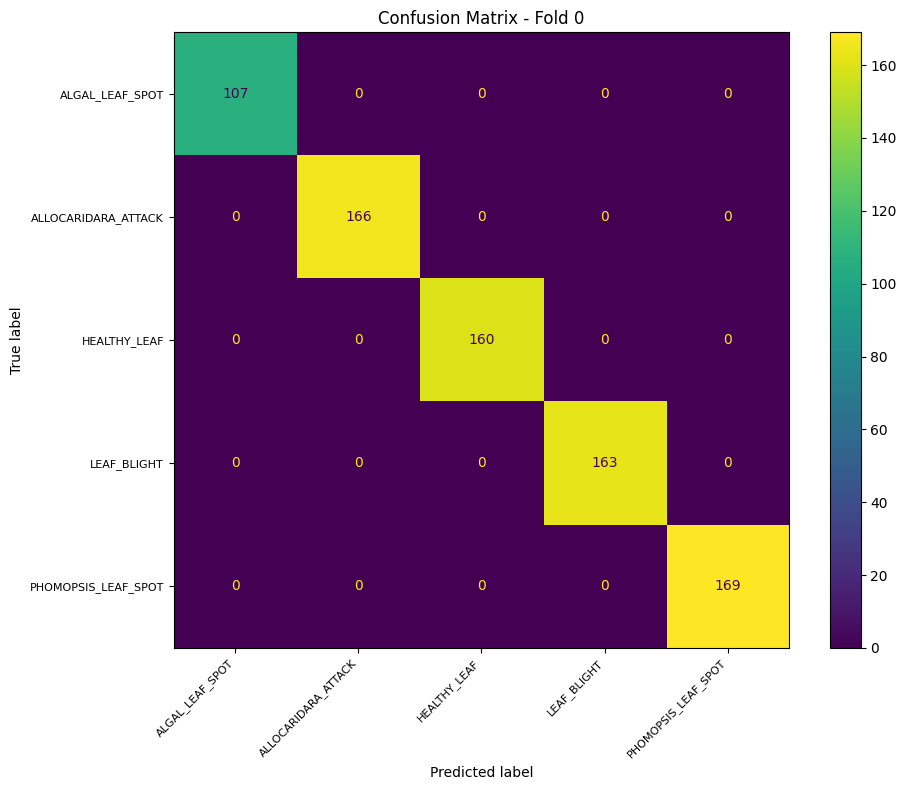

                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT       1.00      1.00      1.00       107
ALLOCARIDARA_ATTACK       1.00      1.00      1.00       166
       HEALTHY_LEAF       1.00      1.00      1.00       160
        LEAF_BLIGHT       1.00      1.00      1.00       163
PHOMOPSIS_LEAF_SPOT       1.00      1.00      1.00       169

           accuracy                           1.00       765
          macro avg       1.00      1.00      1.00       765
       weighted avg       1.00      1.00      1.00       765

--------------------------------------------------


Evaluating Fold 1:   0%|          | 0/96 [00:00<?, ?it/s]


--- Results for Fold: 1 ---


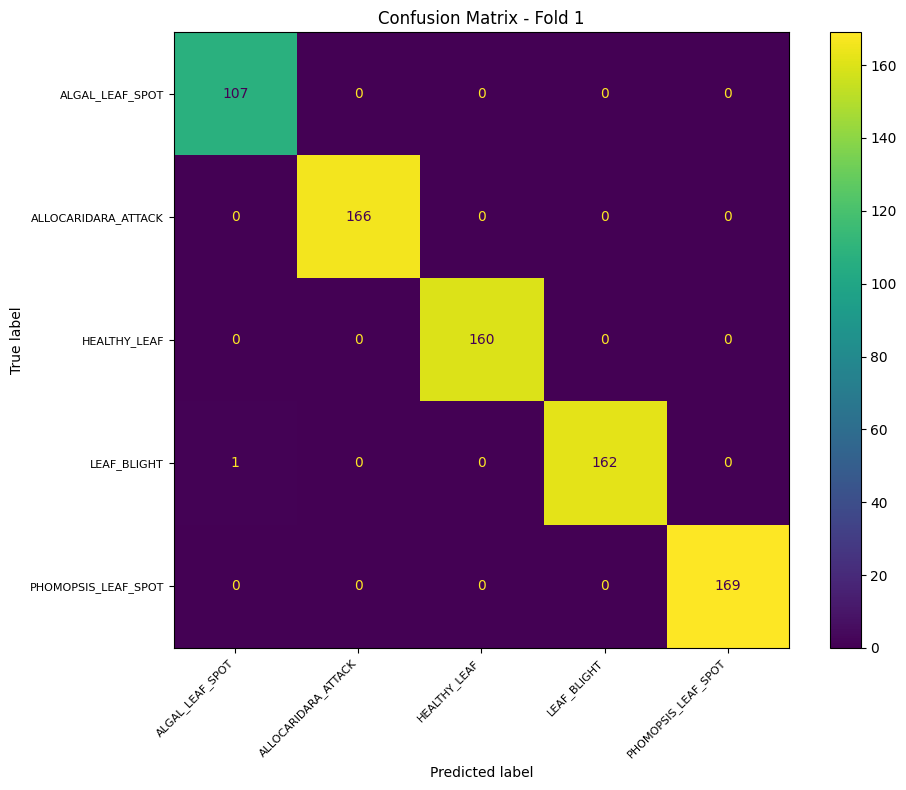

                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT       0.99      1.00      1.00       107
ALLOCARIDARA_ATTACK       1.00      1.00      1.00       166
       HEALTHY_LEAF       1.00      1.00      1.00       160
        LEAF_BLIGHT       1.00      0.99      1.00       163
PHOMOPSIS_LEAF_SPOT       1.00      1.00      1.00       169

           accuracy                           1.00       765
          macro avg       1.00      1.00      1.00       765
       weighted avg       1.00      1.00      1.00       765

--------------------------------------------------


Evaluating Fold 2:   0%|          | 0/96 [00:00<?, ?it/s]


--- Results for Fold: 2 ---


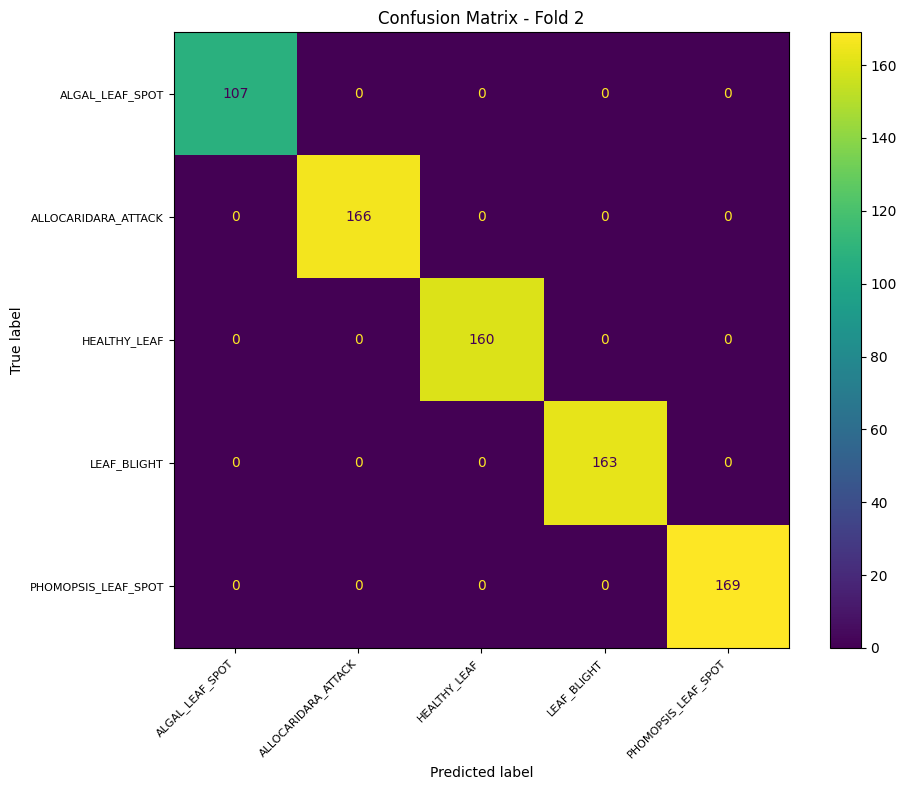

                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT       1.00      1.00      1.00       107
ALLOCARIDARA_ATTACK       1.00      1.00      1.00       166
       HEALTHY_LEAF       1.00      1.00      1.00       160
        LEAF_BLIGHT       1.00      1.00      1.00       163
PHOMOPSIS_LEAF_SPOT       1.00      1.00      1.00       169

           accuracy                           1.00       765
          macro avg       1.00      1.00      1.00       765
       weighted avg       1.00      1.00      1.00       765

--------------------------------------------------


Evaluating Fold 3:   0%|          | 0/96 [00:00<?, ?it/s]


--- Results for Fold: 3 ---


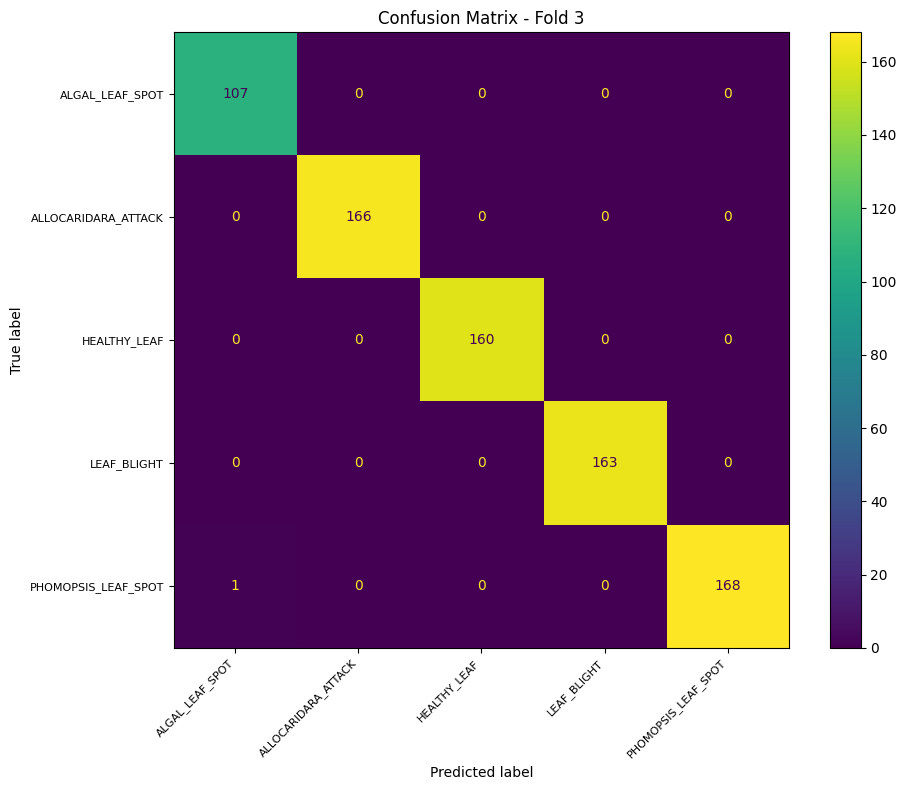

                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT       0.99      1.00      1.00       107
ALLOCARIDARA_ATTACK       1.00      1.00      1.00       166
       HEALTHY_LEAF       1.00      1.00      1.00       160
        LEAF_BLIGHT       1.00      1.00      1.00       163
PHOMOPSIS_LEAF_SPOT       1.00      0.99      1.00       169

           accuracy                           1.00       765
          macro avg       1.00      1.00      1.00       765
       weighted avg       1.00      1.00      1.00       765

--------------------------------------------------


Evaluating Fold 4:   0%|          | 0/96 [00:00<?, ?it/s]


--- Results for Fold: 4 ---


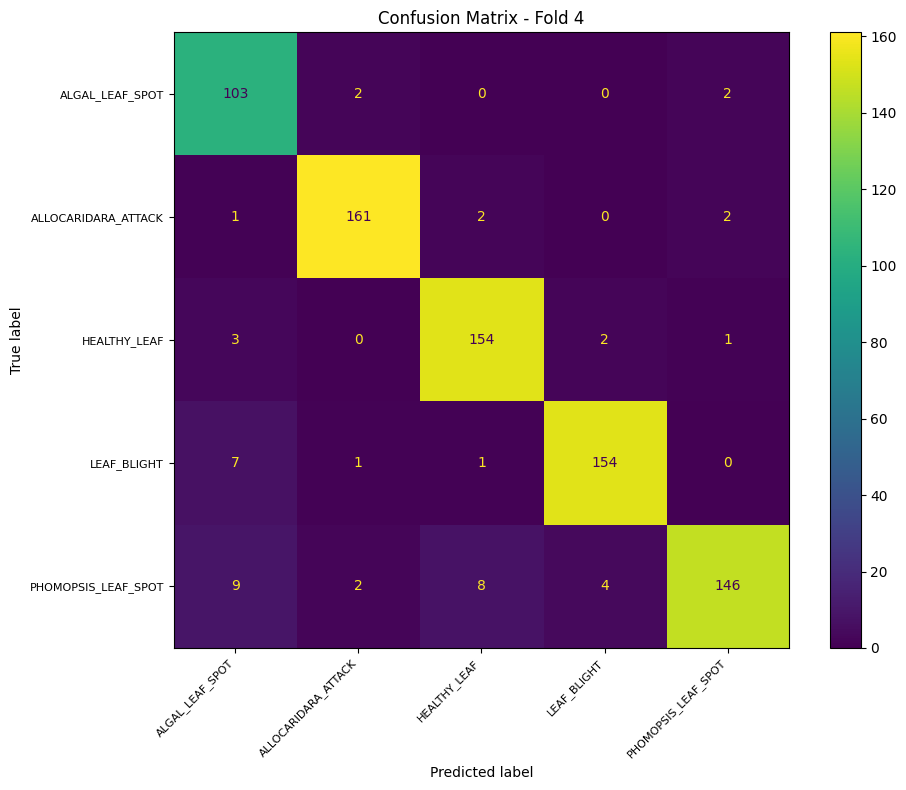

                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT       0.84      0.96      0.90       107
ALLOCARIDARA_ATTACK       0.97      0.97      0.97       166
       HEALTHY_LEAF       0.93      0.96      0.95       160
        LEAF_BLIGHT       0.96      0.94      0.95       163
PHOMOPSIS_LEAF_SPOT       0.97      0.86      0.91       169

           accuracy                           0.94       765
          macro avg       0.93      0.94      0.94       765
       weighted avg       0.94      0.94      0.94       765

--------------------------------------------------


In [54]:
for fold in range(k_splits):
    predictions = []
    references = []

    loaded_model = torch.load(f"efficientnetv2_checkpoint_fold{fold}.pt", weights_only=False)
    loaded_model.eval()
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f"Evaluating Fold {fold}"):
            inputs, targets = batch
            outputs = loaded_model(inputs.to(device))

            predictions += outputs.argmax(-1).detach().cpu().tolist()
            references += targets.tolist()

    print(f"\n--- Results for Fold: {fold} ---")

    cm = confusion_matrix(references, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classname)

    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

    plt.title(f"Confusion Matrix - Fold {fold}")
    plt.tight_layout()
    plt.show()

    print(classification_report(references, predictions, target_names=classname))
    print("-" * 50) #

In [34]:
classname = dataset.classes
classname

['ALGAL_LEAF_SPOT',
 'ALLOCARIDARA_ATTACK',
 'HEALTHY_LEAF',
 'LEAF_BLIGHT',
 'PHOMOPSIS_LEAF_SPOT']

In [35]:
# Making Dataset
test_dataset = datasets.ImageFolder(root=test_dir,
                               transform=data_transforms["test"], # ใช้ data_transforms แทน
                               target_transform=None)# transforms to perform on labels (if necessary)

In [36]:
len(test_dataset)

612

In [37]:
# Making test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=eval_batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [38]:
test_dataset.classes

['ALGAL_LEAF_SPOT',
 'ALLOCARIDARA_ATTACK',
 'HEALTHY_LEAF',
 'LEAF_BLIGHT',
 'PHOMOPSIS_LEAF_SPOT']

In [39]:
len(test_dataloader)

77

Evaluating Fold 0:   0%|          | 0/77 [00:00<?, ?it/s]


--- Results for Fold: 0 ---


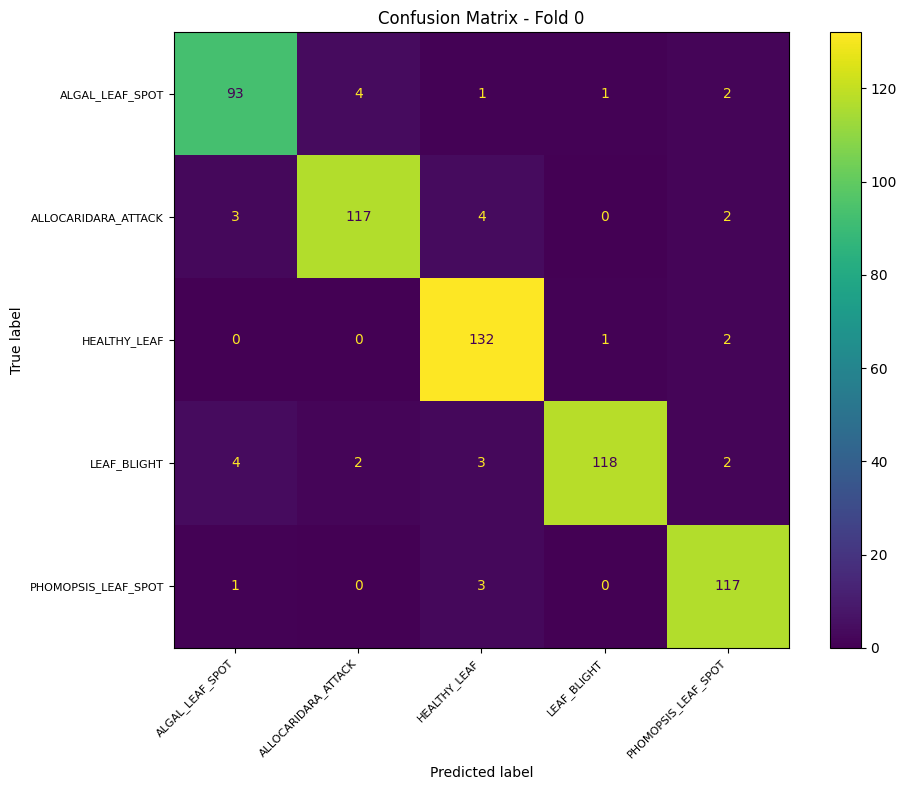

                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT       0.92      0.92      0.92       101
ALLOCARIDARA_ATTACK       0.95      0.93      0.94       126
       HEALTHY_LEAF       0.92      0.98      0.95       135
        LEAF_BLIGHT       0.98      0.91      0.95       129
PHOMOPSIS_LEAF_SPOT       0.94      0.97      0.95       121

           accuracy                           0.94       612
          macro avg       0.94      0.94      0.94       612
       weighted avg       0.94      0.94      0.94       612

--------------------------------------------------


Evaluating Fold 1:   0%|          | 0/77 [00:00<?, ?it/s]


--- Results for Fold: 1 ---


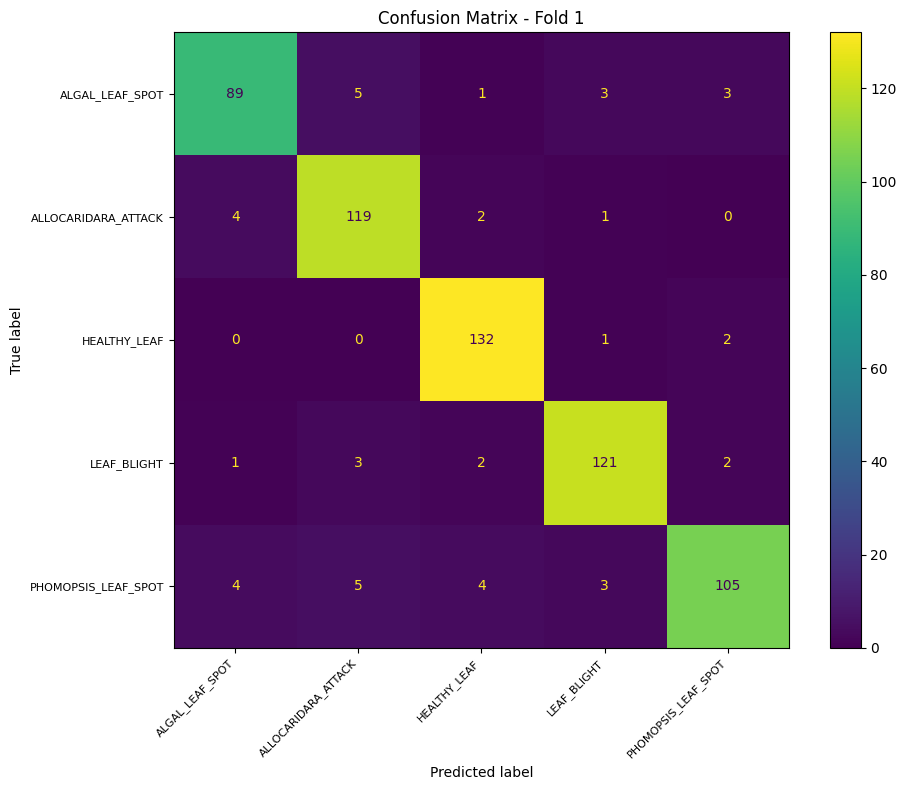

                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT       0.91      0.88      0.89       101
ALLOCARIDARA_ATTACK       0.90      0.94      0.92       126
       HEALTHY_LEAF       0.94      0.98      0.96       135
        LEAF_BLIGHT       0.94      0.94      0.94       129
PHOMOPSIS_LEAF_SPOT       0.94      0.87      0.90       121

           accuracy                           0.92       612
          macro avg       0.92      0.92      0.92       612
       weighted avg       0.93      0.92      0.92       612

--------------------------------------------------


Evaluating Fold 2:   0%|          | 0/77 [00:00<?, ?it/s]


--- Results for Fold: 2 ---


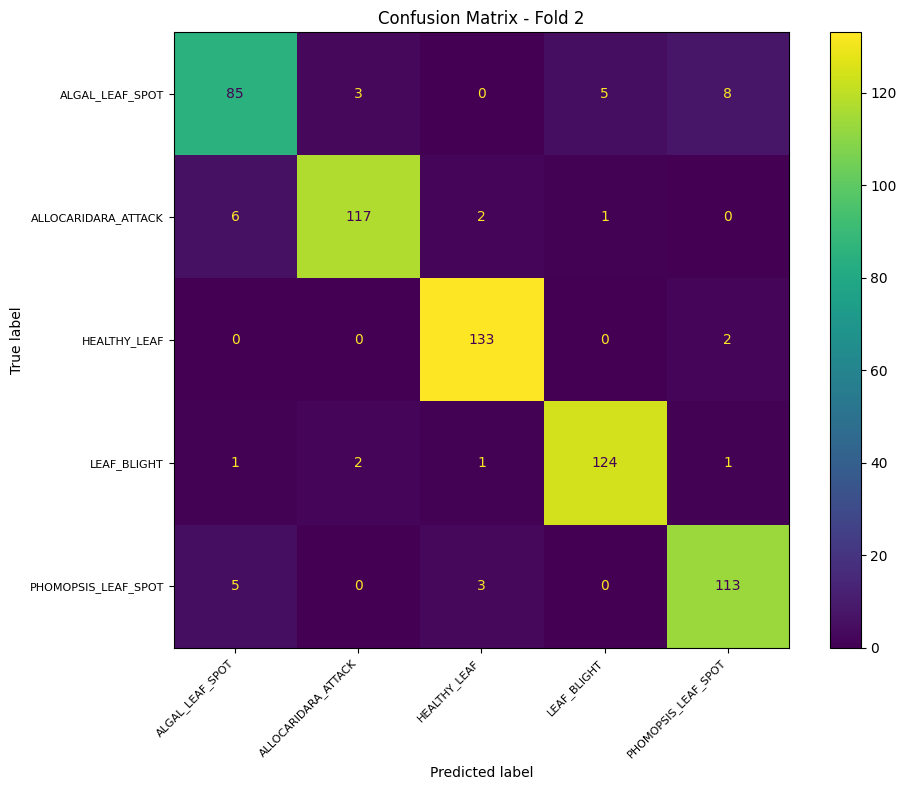

                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT       0.88      0.84      0.86       101
ALLOCARIDARA_ATTACK       0.96      0.93      0.94       126
       HEALTHY_LEAF       0.96      0.99      0.97       135
        LEAF_BLIGHT       0.95      0.96      0.96       129
PHOMOPSIS_LEAF_SPOT       0.91      0.93      0.92       121

           accuracy                           0.93       612
          macro avg       0.93      0.93      0.93       612
       weighted avg       0.93      0.93      0.93       612

--------------------------------------------------


Evaluating Fold 3:   0%|          | 0/77 [00:00<?, ?it/s]


--- Results for Fold: 3 ---


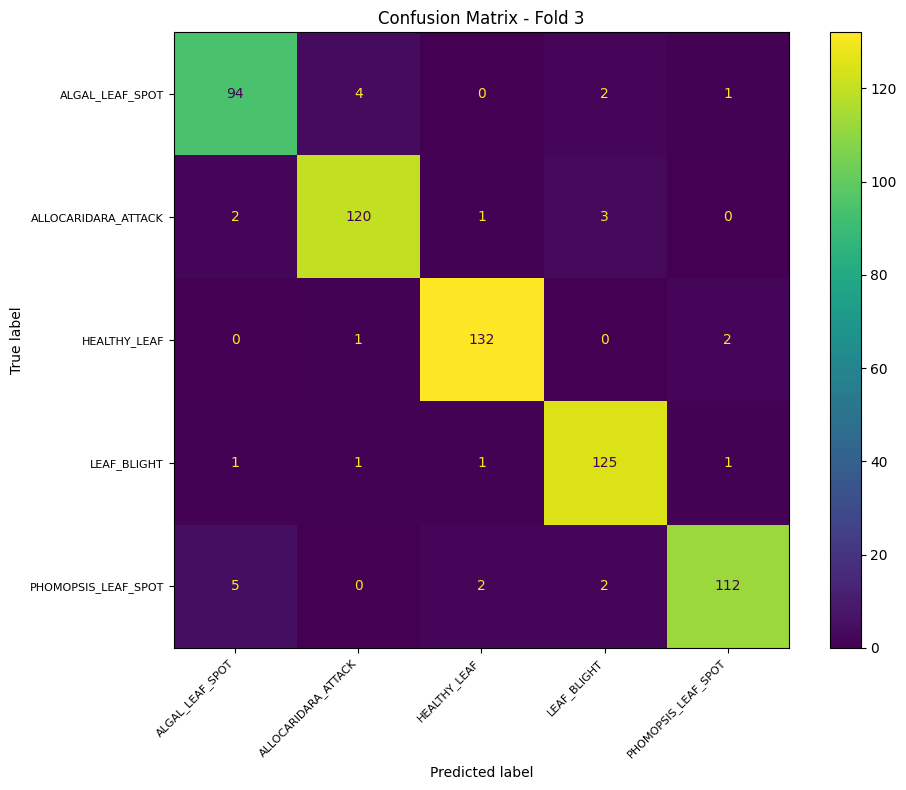

                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT       0.92      0.93      0.93       101
ALLOCARIDARA_ATTACK       0.95      0.95      0.95       126
       HEALTHY_LEAF       0.97      0.98      0.97       135
        LEAF_BLIGHT       0.95      0.97      0.96       129
PHOMOPSIS_LEAF_SPOT       0.97      0.93      0.95       121

           accuracy                           0.95       612
          macro avg       0.95      0.95      0.95       612
       weighted avg       0.95      0.95      0.95       612

--------------------------------------------------


Evaluating Fold 4:   0%|          | 0/77 [00:00<?, ?it/s]


--- Results for Fold: 4 ---


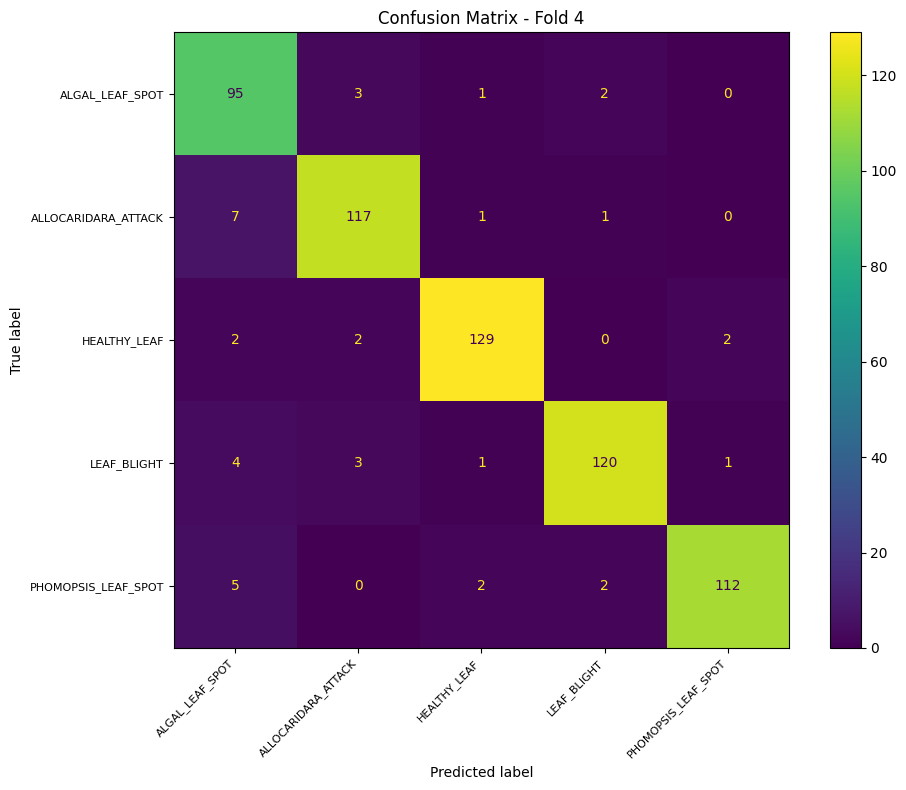

                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT       0.84      0.94      0.89       101
ALLOCARIDARA_ATTACK       0.94      0.93      0.93       126
       HEALTHY_LEAF       0.96      0.96      0.96       135
        LEAF_BLIGHT       0.96      0.93      0.94       129
PHOMOPSIS_LEAF_SPOT       0.97      0.93      0.95       121

           accuracy                           0.94       612
          macro avg       0.93      0.94      0.93       612
       weighted avg       0.94      0.94      0.94       612

--------------------------------------------------


In [61]:
for fold in range(k_splits):
    predictions = []
    references = []

    loaded_model = torch.load(f"efficientnetv2_checkpoint_fold{fold}.pt", weights_only=False)
    loaded_model.eval()
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc=f"Evaluating Fold {fold}"):
            inputs, targets = batch
            outputs = loaded_model(inputs.to(device))

            predictions += outputs.argmax(-1).detach().cpu().tolist()
            references += targets.tolist()

    print(f"\n--- Results for Fold: {fold} ---")

    cm = confusion_matrix(references, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classname)

    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

    plt.title(f"Confusion Matrix - Fold {fold}")
    plt.tight_layout()
    plt.show()

    print(classification_report(references, predictions, target_names=classname))
    print("-" * 50) #

## Visualization train model result

In [40]:
## Making Pridcition return class & prob
from typing import List, Tuple

from PIL import Image
def pred_class(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: T = None,
                        device: torch.device=device):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    classname =  class_names[target_image_pred_label]
    prob = target_image_pred_probs.max().cpu().numpy()

    return classname , prob

In [41]:
##Load some model
loaded_model = torch.load('efficientnetv2_checkpoint_fold3.pt', weights_only=False)

## Train data visulization

In [42]:
#Making df for rando
import os
import pandas as pd
from PIL import Image

# create an empty list to store image paths
image_paths = []

# loop through each subfolder in the "Image" directory
for root, dirs, files in os.walk("./../../data/test/"):
    for subfolder_name in dirs:
        # get the path to the subfolder
        subfolder_path = os.path.join(root, subfolder_name)
        # loop through each file in the subfolder
        for filename in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, filename)
            image_paths.append((image_path, subfolder_name))

# create a DataFrame from the list of image paths
df = pd.DataFrame(image_paths, columns=['path', 'subfolder_name'])


In [43]:
df.sample(10)

path       subfolder_name
406    ./../../data/test/LEAF_BLIGHT\to_label_2956.jpg          LEAF_BLIGHT
248   ./../../data/test/HEALTHY_LEAF\to_label_1853.jpg         HEALTHY_LEAF
558  ./../../data/test/PHOMOPSIS_LEAF_SPOT\to_label...  PHOMOPSIS_LEAF_SPOT
405    ./../../data/test/LEAF_BLIGHT\to_label_2954.jpg          LEAF_BLIGHT
355   ./../../data/test/HEALTHY_LEAF\to_label_2649.jpg         HEALTHY_LEAF
308   ./../../data/test/HEALTHY_LEAF\to_label_2294.jpg         HEALTHY_LEAF
236   ./../../data/test/HEALTHY_LEAF\to_label_1770.jpg         HEALTHY_LEAF
161  ./../../data/test/ALLOCARIDARA_ATTACK\to_label...  ALLOCARIDARA_ATTACK
219  ./../../data/test/ALLOCARIDARA_ATTACK\to_label...  ALLOCARIDARA_ATTACK
495  ./../../data/test/PHOMOPSIS_LEAF_SPOT\to_label...  PHOMOPSIS_LEAF_SPOT

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image



def sample_picture(df=df,random_state=None):
    # Sample 20 random rows from the DataFrame
    sample_df = df.sample(20, random_state=random_state).copy()
    sample_df = sample_df.reset_index(drop=True)
    # Define the grid layout for displaying the images
    num_rows = 4
    num_cols = 5
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 12))
    fig.tight_layout(pad=5.0)

    # Iterate over the sampled rows and display the images in the grid
    for i, row in sample_df.iterrows():
        img = Image.open(row['path'])

        # Prediction
        pred_name , prob = pred_class(model=loaded_model,image_path=row['path'],
                   class_names = classname,
                   transform=data_transforms["test"])

        row_idx = i // num_cols
        col_idx = i % num_cols
        axs[row_idx, col_idx].imshow(img)
        axs[row_idx, col_idx].axis('on')
        axs[row_idx, col_idx].set_title(row['subfolder_name'] + ': \nPredict:' + pred_name + '\nProb:'+ str(prob.round(decimals=2)) )

        # prediction


    plt.show()

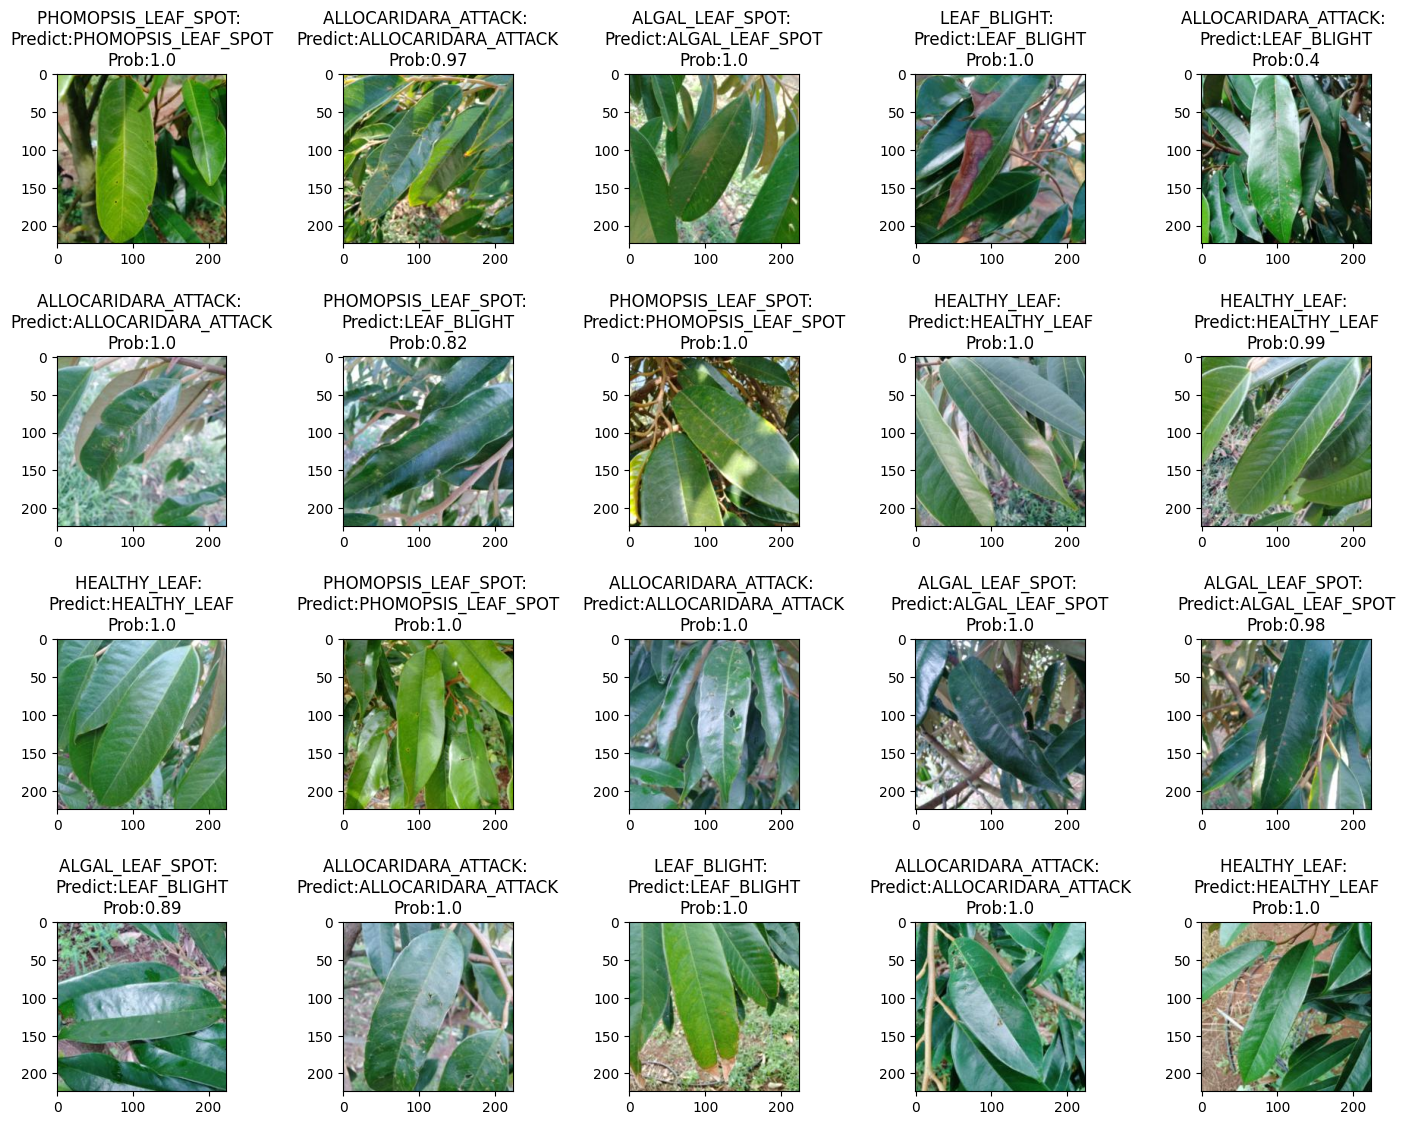

In [45]:
sample_picture()

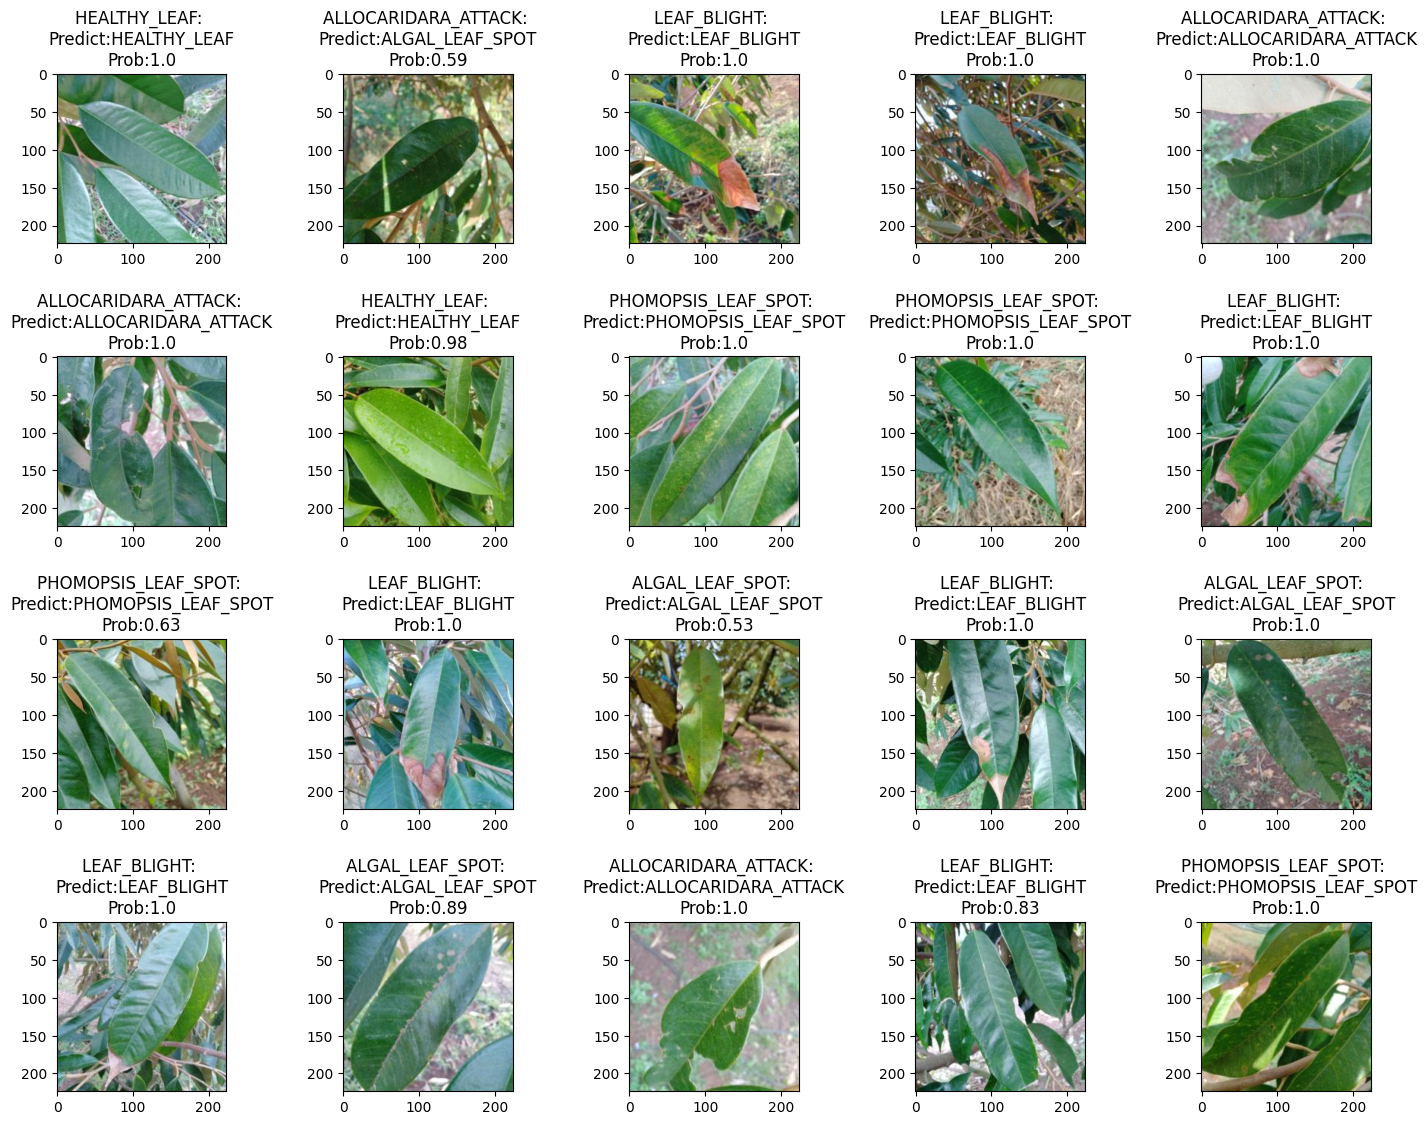

In [46]:
sample_picture()

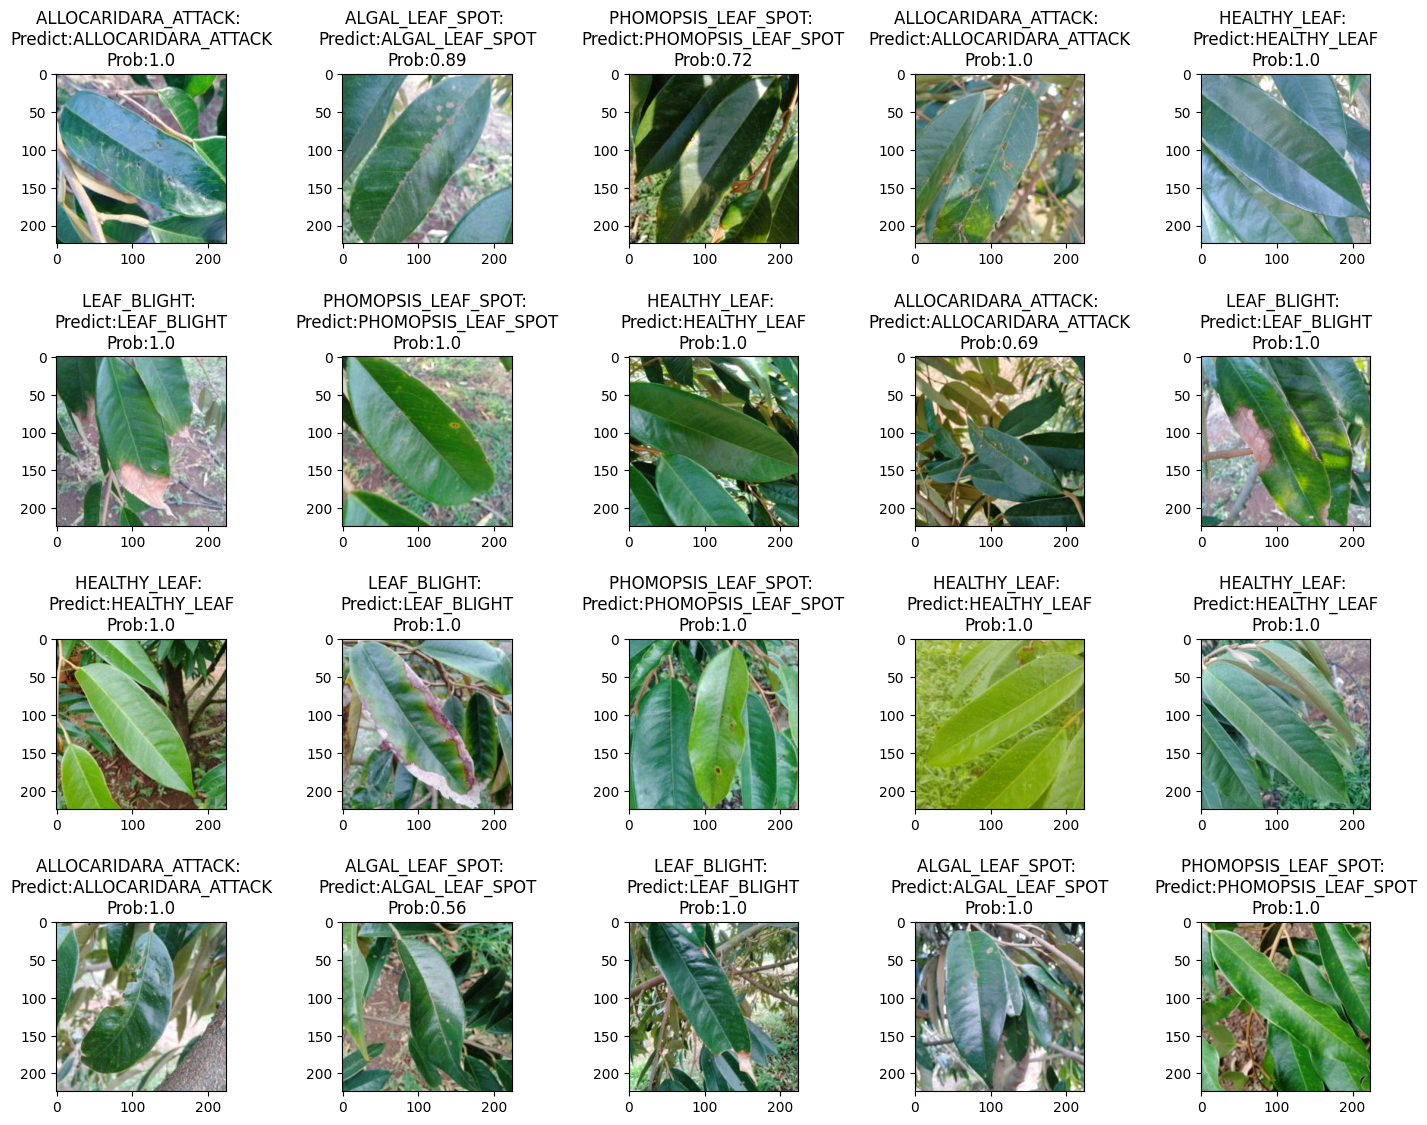

In [47]:
sample_picture()

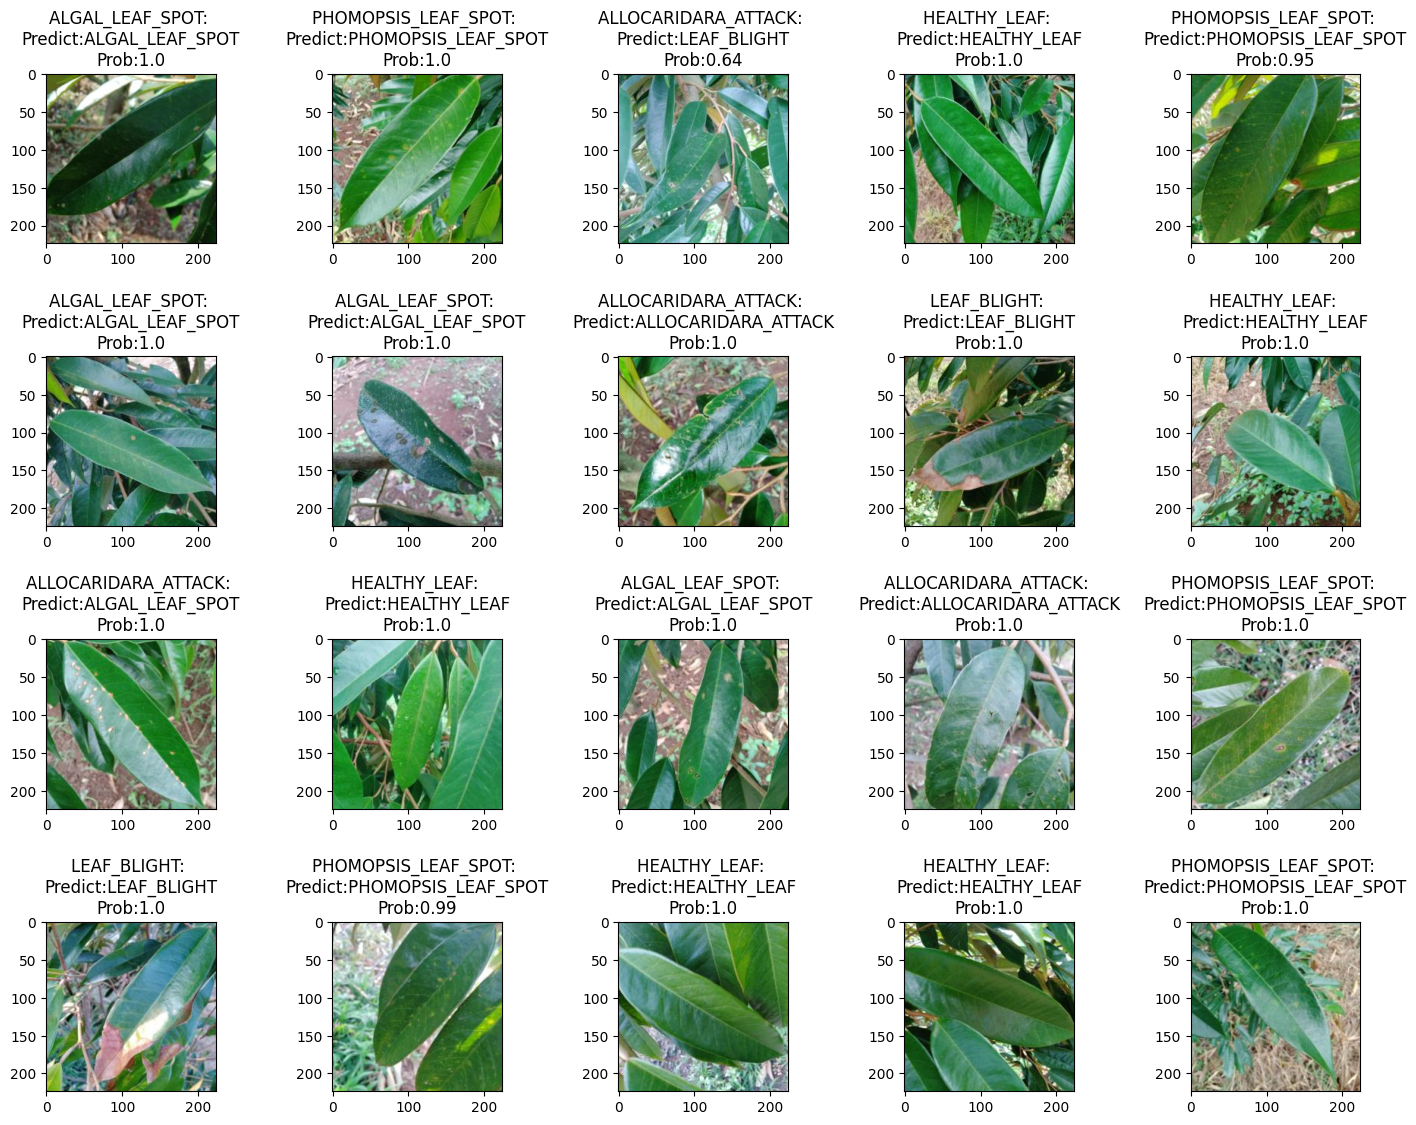

In [48]:
sample_picture()

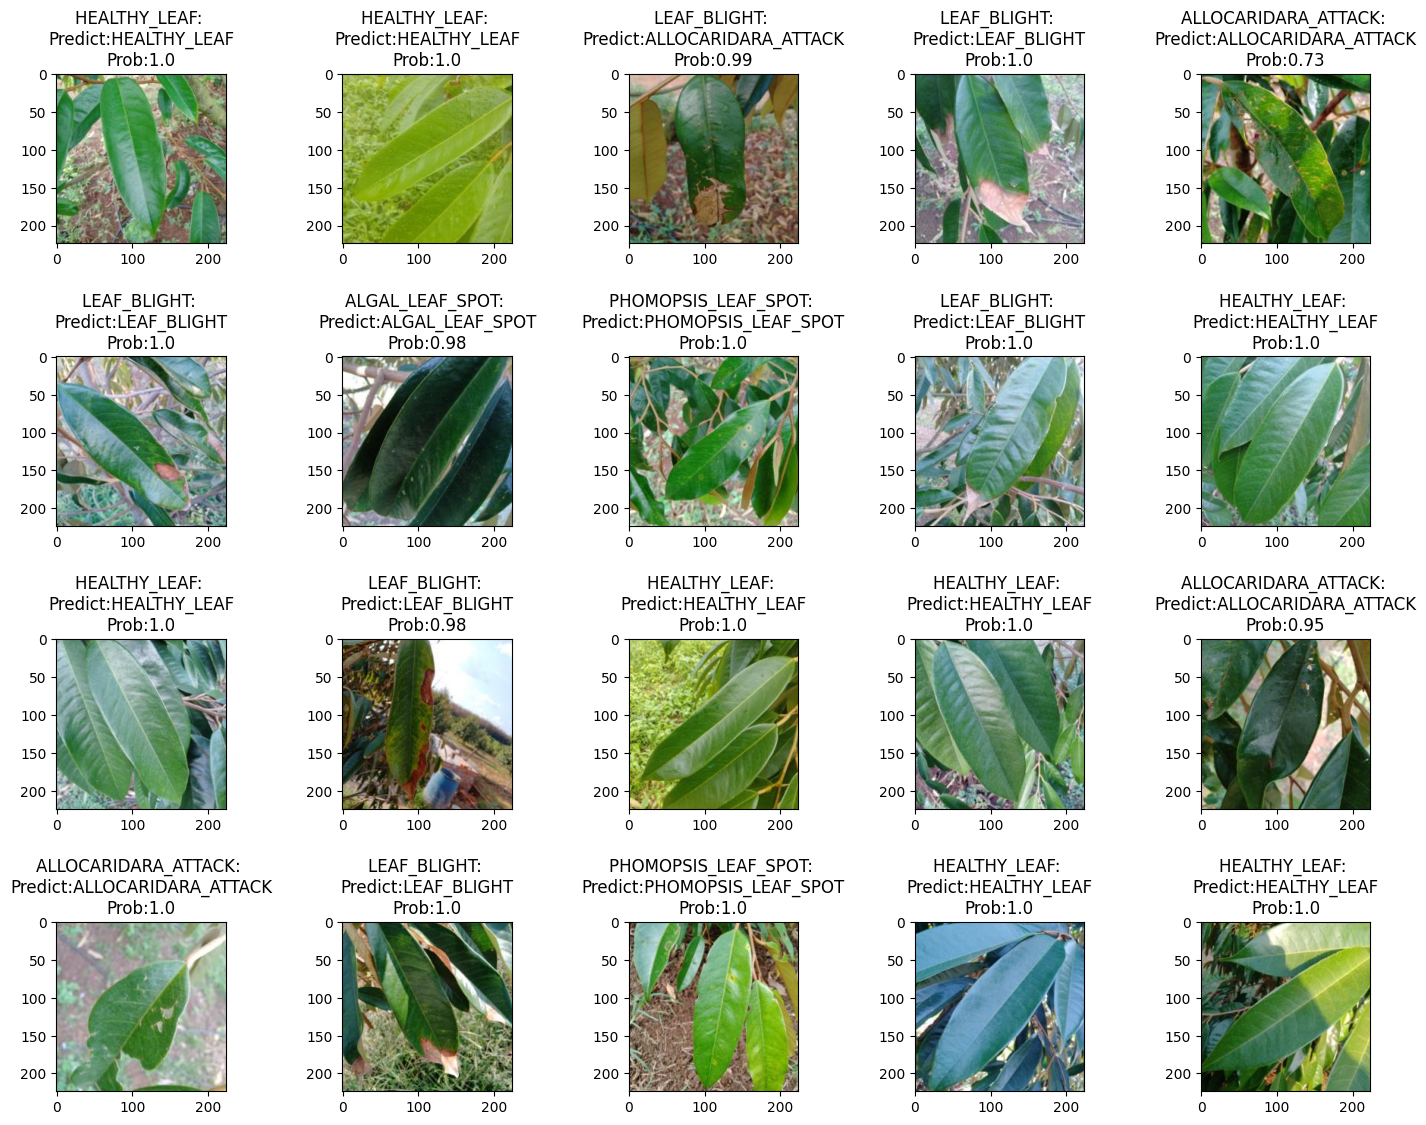

In [49]:
sample_picture()